# Automatic WhatsApp Analyzer (String-Split Method)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tkinter import Tk, filedialog

✅ File selected: C:/Users/HP/OneDrive/Desktop/Python Script/WhatsApp Chat with Oil -- Terrorism -- Slavery.txt
✅ Parsed 12095 messages

--- Top 5 Active People ---
Name
Omo Jesu        3886
Farsan Batie    3380
genghis         1179
Adigun          1163
HakRaj          1083
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_19748\68351114.py:48: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


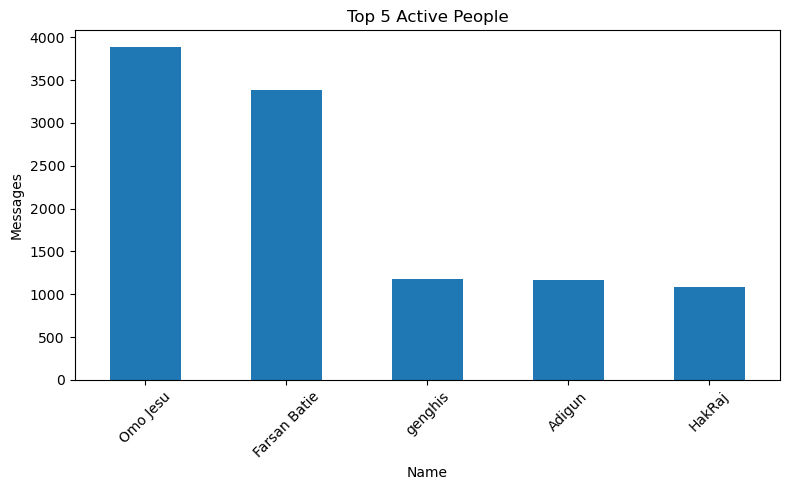

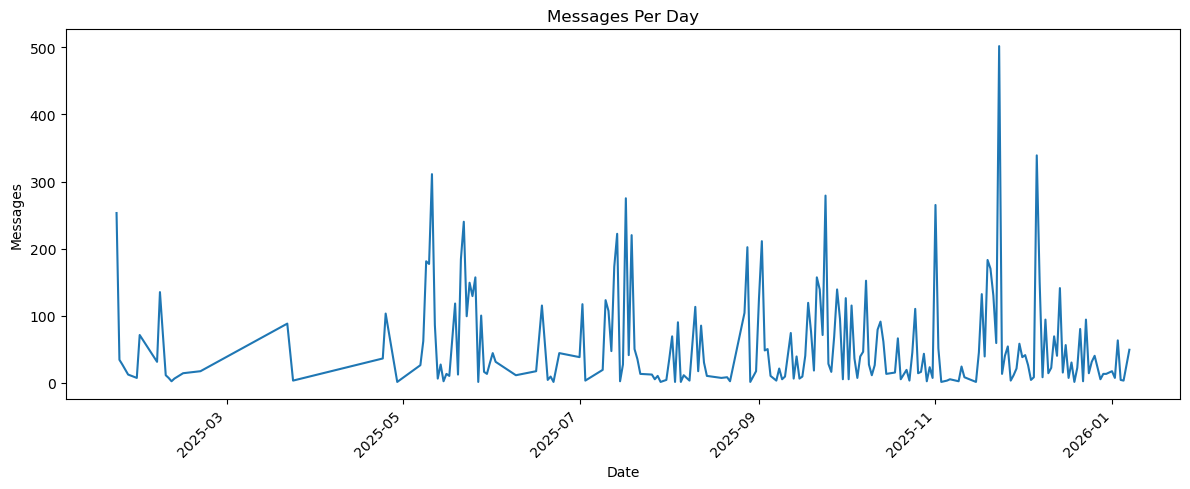

✅ Cleaned chat saved


In [2]:
MESSAGE_PATTERN = re.compile(
    r'^(\d{1,2}[\/.-]\d{1,2}[\/.-]\d{2,4}),\s'
    r'(\d{1,2}:\d{2}(?:\s?[APMapm]{2})?)\s-\s'
    r'([^:]+):\s(.*)$'
)

def run_whatsapp_analysis():
    root = Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename(
        title="Select WhatsApp Chat .txt file",
        filetypes=[("Text files", "*.txt")]
    )

    if not file_path:
        print("❌ No file selected.")
        return

    print(f"✅ File selected: {file_path}")

    data = []
    current_message = None

    with open(file_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            match = MESSAGE_PATTERN.match(line)

            if match:
                if current_message:
                    data.append(current_message)
                current_message = list(match.groups())
            else:
                if current_message:
                    current_message[3] += " " + line

        if current_message:
            data.append(current_message)

    df = pd.DataFrame(data, columns=["Date", "Time", "Name", "Message"])

    if df.empty:
        print("❌ No messages parsed. Check chat format.")
        return

    df["Length of Message"] = df["Message"].str.len()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    print(f"✅ Parsed {len(df)} messages")

    # ─── Top 5 Active People ─────────────────────────────
    print("\n--- Top 5 Active People ---")
    top_senders = df["Name"].value_counts().head(5)
    print(top_senders)

    if not top_senders.empty:
        plt.figure(figsize=(8,5))
        top_senders.plot(kind="bar")
        plt.title("Top 5 Active People")
        plt.ylabel("Messages")
        plt.xlabel("Name")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No sender data to plot.")

    # ─── Messages per Day ────────────────────────────────
    messages_per_day = df["Date"].value_counts().sort_index()

    if not messages_per_day.empty:
        plt.figure(figsize=(12,5))
        messages_per_day.plot()
        plt.title("Messages Per Day")
        plt.ylabel("Messages")
        plt.xlabel("Date")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No daily data to plot.")

    df.to_csv("cleaned_whatsapp_chat.csv", index=False)
    print("✅ Cleaned chat saved")

run_whatsapp_analysis()
